In [1]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image
# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
data = '/content/gdrive/MyDrive/Colab Notebooks/SolarPanel/Faulty_solar_panel'
filepaths = []
labels = []

folds = os.listdir(data)
for fold in folds:
    foldpath = os.path.join(data, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
data = pd.concat([Fseries, Lseries], axis= 1)

In [4]:
data

filepaths        labels
0    /content/gdrive/MyDrive/Colab Notebooks/SolarP...     Bird-drop
1    /content/gdrive/MyDrive/Colab Notebooks/SolarP...     Bird-drop
2    /content/gdrive/MyDrive/Colab Notebooks/SolarP...     Bird-drop
3    /content/gdrive/MyDrive/Colab Notebooks/SolarP...     Bird-drop
4    /content/gdrive/MyDrive/Colab Notebooks/SolarP...     Bird-drop
..                                                 ...           ...
871  /content/gdrive/MyDrive/Colab Notebooks/SolarP...  Snow-Covered
872  /content/gdrive/MyDrive/Colab Notebooks/SolarP...  Snow-Covered
873  /content/gdrive/MyDrive/Colab Notebooks/SolarP...  Snow-Covered
874  /content/gdrive/MyDrive/Colab Notebooks/SolarP...  Snow-Covered
875  /content/gdrive/MyDrive/Colab Notebooks/SolarP...  Snow-Covered

[876 rows x 2 columns]

In [5]:
# train dataframe
train_df, dummy_df = train_test_split(data,  train_size= 0.8, shuffle= True, random_state= 123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.6, shuffle= True, random_state= 123)

In [6]:
# crobed image size
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()
train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 693 validated image filenames belonging to 6 classes.
Found 105 validated image filenames belonging to 6 classes.
Found 71 validated image filenames belonging to 6 classes.


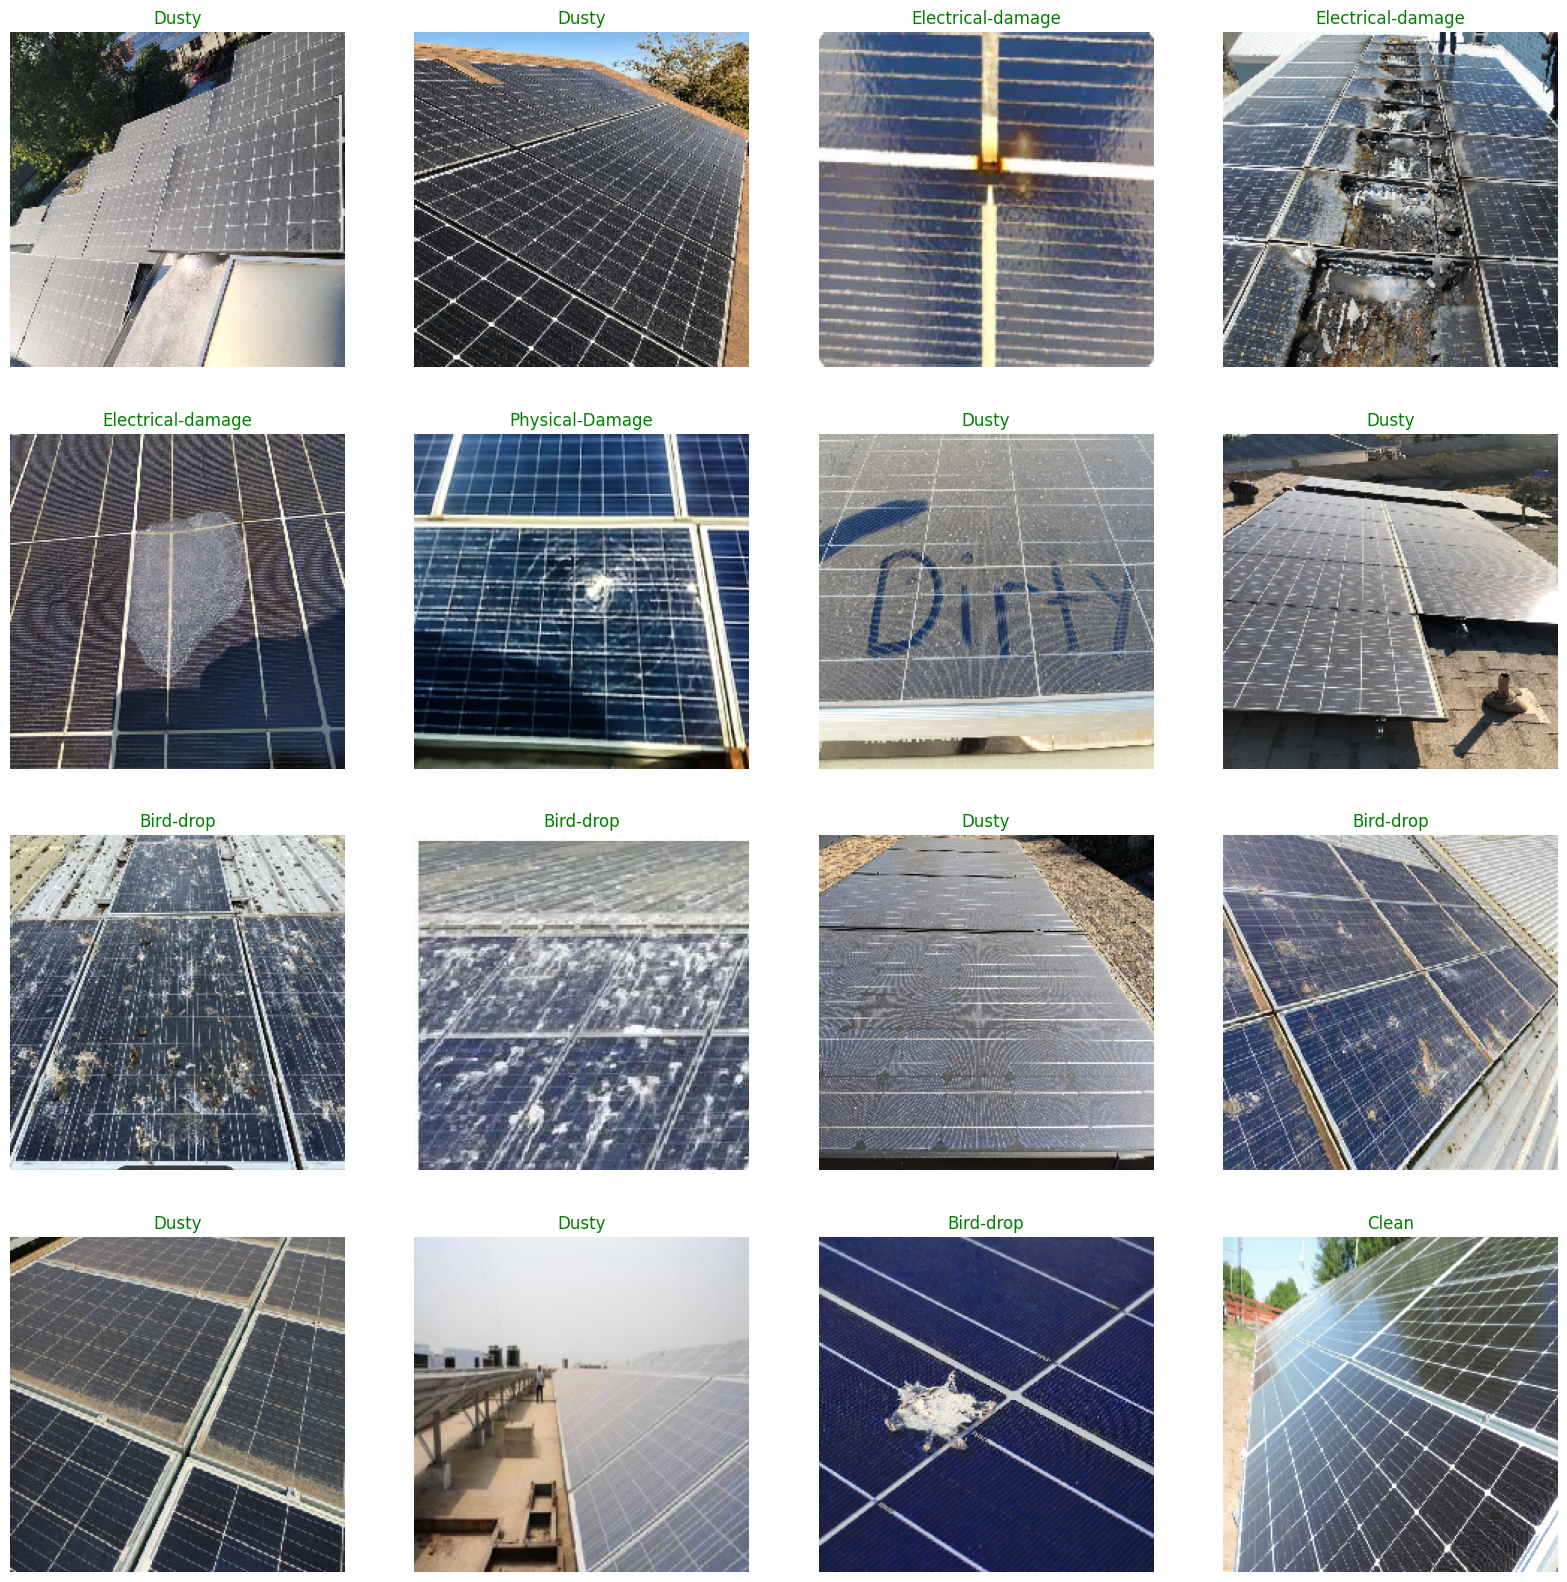

In [9]:
g_dict = train_gen.class_indices
classes = list(g_dict.keys())
images, labels = next(train_gen)

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name, color= 'green', fontsize= 12)
    plt.axis('off')
plt.show()

In [36]:

img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

base_model = tf.keras.applications.densenet.DenseNet121(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
#base_model = tf.keras.applications.vgg16.VGG16(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
#base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
# base_model.trainable = False
model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 1024)              7037504   
                                                                 
 batch_normalization_4 (Bat  (None, 1024)              4096      
 chNormalization)                                                
                                                                 
 dense_8 (Dense)             (None, 256)               262400    
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 6)                 1542      
                                                                 
Total params: 7305542 (27.87 MB)
Trainable params: 7219846 (27.54 MB)
Non-trainable params: 85696 (334.75 KB)
__________

In [37]:
batch_size = 20
epochs =  25

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen,
                    validation_steps= None, shuffle= False)

Epoch 1/25
44/44 [==============================] - 72s 465ms/step - loss: 7.6366 - accuracy: 0.5195 - val_loss: 7.9951 - val_accuracy: 0.4286
Epoch 2/25
44/44 [==============================] - 18s 402ms/step - loss: 5.9614 - accuracy: 0.7691 - val_loss: 6.0378 - val_accuracy: 0.6857
Epoch 3/25
44/44 [==============================] - 20s 455ms/step - loss: 5.0121 - accuracy: 0.8947 - val_loss: 5.1977 - val_accuracy: 0.7810
Epoch 4/25
44/44 [==============================] - 18s 405ms/step - loss: 4.4095 - accuracy: 0.9408 - val_loss: 4.5864 - val_accuracy: 0.8286
Epoch 5/25
44/44 [==============================] - 19s 428ms/step - loss: 3.9824 - accuracy: 0.9582 - val_loss: 4.2266 - val_accuracy: 0.8000
Epoch 6/25
44/44 [==============================] - 18s 396ms/step - loss: 3.6138 - accuracy: 0.9856 - val_loss: 3.8837 - val_accuracy: 0.8667
Epoch 7/25
44/44 [==============================] - 17s 397ms/step - loss: 3.3387 - accuracy: 0.9755 - val_loss: 3.5509 - val_accuracy: 0.8857

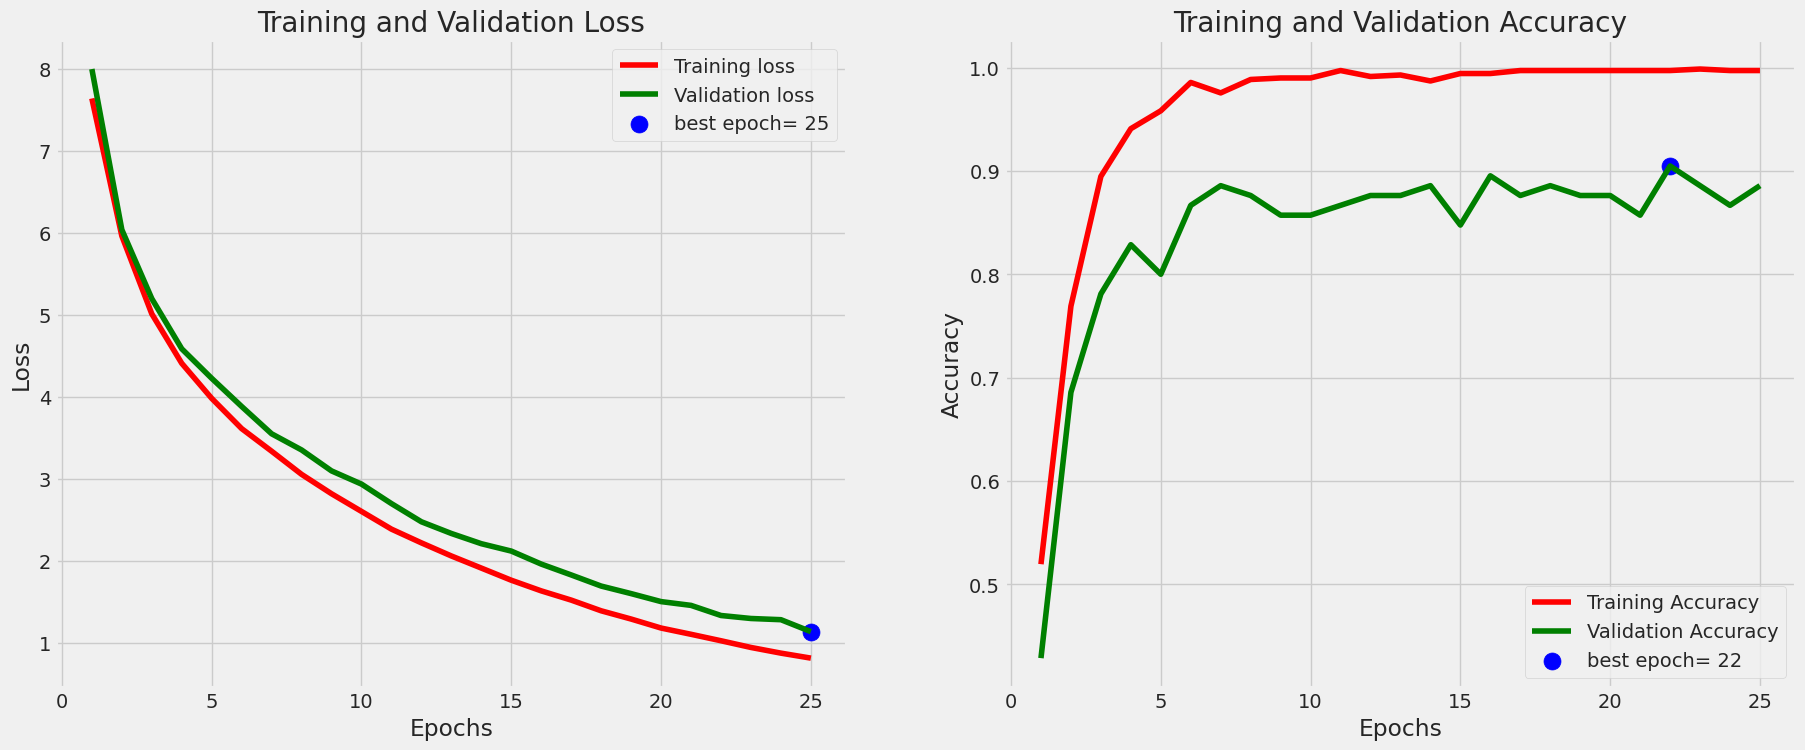

In [48]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'
# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show()

In [49]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

1/1 [==============================] - 1s 538ms/step - loss: 1.1208 - accuracy: 0.8750
Train Loss:  0.7558902502059937
Train Accuracy:  1.0
--------------------
Validation Loss:  1.0272284746170044
Validation Accuracy:  0.9375
--------------------
Test Loss:  1.1208484172821045
Test Accuracy:  0.875


In [50]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

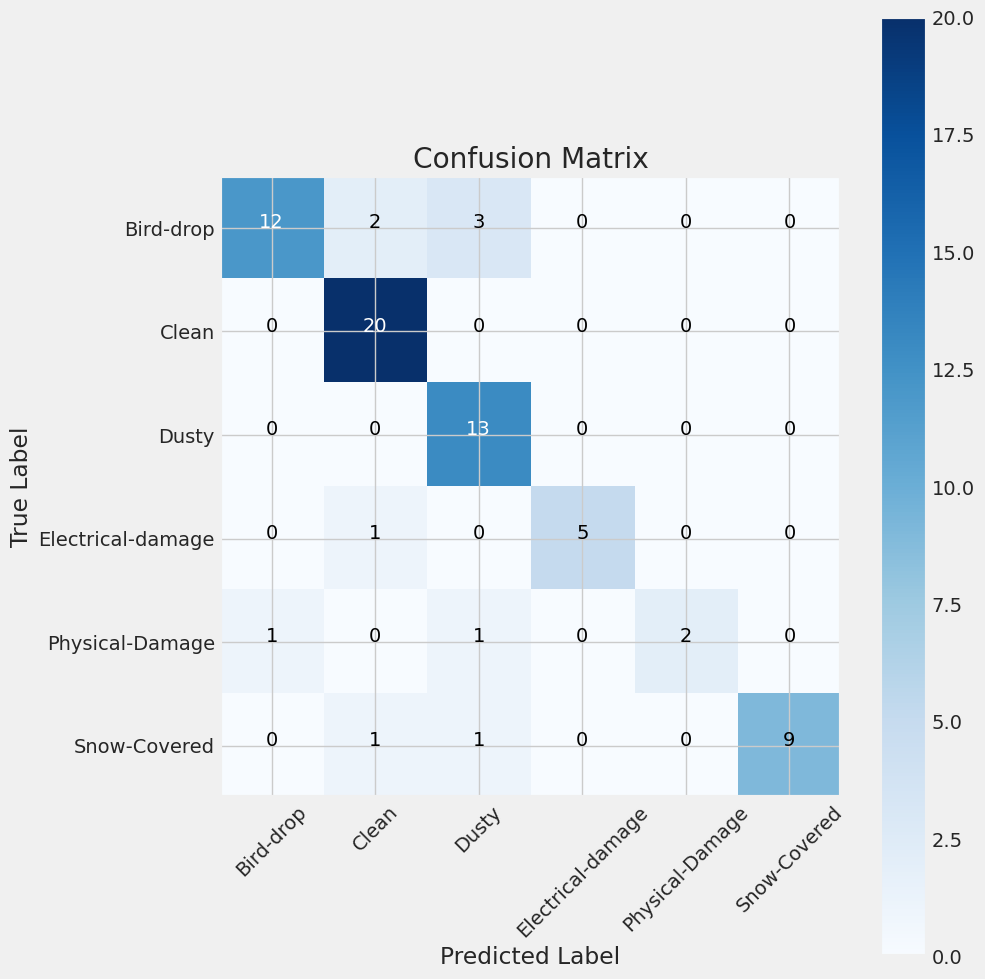

In [51]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
    plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [52]:
print(classification_report(test_gen.classes, y_pred, target_names= classes))

                   precision    recall  f1-score   support

        Bird-drop       0.92      0.71      0.80        17
            Clean       0.83      1.00      0.91        20
            Dusty       0.72      1.00      0.84        13
Electrical-damage       1.00      0.83      0.91         6
  Physical-Damage       1.00      0.50      0.67         4
     Snow-Covered       1.00      0.82      0.90        11

         accuracy                           0.86        71
        macro avg       0.91      0.81      0.84        71
     weighted avg       0.88      0.86      0.86        71



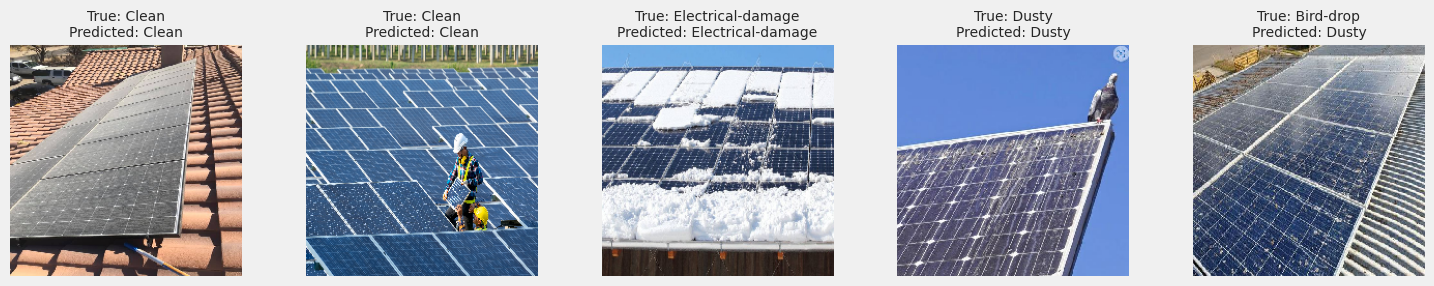

In [85]:
true_labels = test_gen.classes
num_samples_to_display = min(5, len(test_gen))
num_rows = 1
num_cols = num_samples_to_display // num_rows

indices = np.random.choice(len(test_gen), num_samples_to_display, replace=False)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3))
for i, idx in enumerate(indices):
    images, labels = test_gen[idx]
    image = images[0]

    image = image.astype('float32') / 255.0
    true_label = classes[true_labels[idx]]
    predicted_label = classes[y_pred[idx]]

    ax = axes[i]
    ax.imshow(image)
    ax.set_title(f"True: {true_label}\nPredicted: {predicted_label}", fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
#Save the model
model.save('Solar Panel dust.h5')

In [ ]:
loaded_model = tf.keras.models.load_model('/content/Solar Panel dust.h5', compile=False)
loaded_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [ ]:
image_path = '/content/ornek.jpg'
image = Image.open(image_path)

# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = classes
score = tf.nn.softmax(predictions[0])
print(f"{class_labels[tf.argmax(score)]}")

1/1 [==============================] - 0s 78ms/step
Dusty
